# Slope Analysis from Raster Data

• Slope analysis is a key terrain analysis technique used in GIS and spatial analysis to measure the steepness or incline of the terrain at any given point. 

• It is calculated by examining the rate of change in elevation between neighboring pixels in a digital elevation model (DEM). 

• Slope analysis helps identify areas with steep gradients, which is useful in applications like land-use planning, erosion risk assessment, hydrological modeling, seismic-induced landslide risk, and infrastructure development. 

• The slope is typically expressed in degrees or as a percentage.

• It is very simple to compute, using the Pythagorean formula

$$\text{slope}=\sqrt{\left(\frac{\Delta z}{\Delta x}\right)^{2}+\left(\frac{\Delta z}{\Delta y}\right)^{2}}$$

See [AutoGIS](https://autogis-site.readthedocs.io/en/latest/lessons/lesson-7/Raster-processing.html#Raster-to-Raster-Calculations).

This notebook requires installation of `rioxarray`,  a python package that is built upon the `xarray` and `rasterio` packages to facilitate the analysis of raster or xarray datasets.

In this use-case we will follow these steps:

1. Load Philippines DEM data that was sourced from USGS [EarthExolorer](https://earthexplorer.usgs.gov/) site.
2. Use `rioxarray`functions,  which extends `xarray` with the `rio` (raster IO) accessor, to open and plot the DEM.
3. Compute gradients and slope and display the result.
4. Compute the SSI (see below) and display the result.


Screenshot from the USGS site:

![](EarthExplorer-DEM.png)

Instructions can be found in this [video tutorial](https://www.youtube.com/watch?v=yYWdxExabHo).

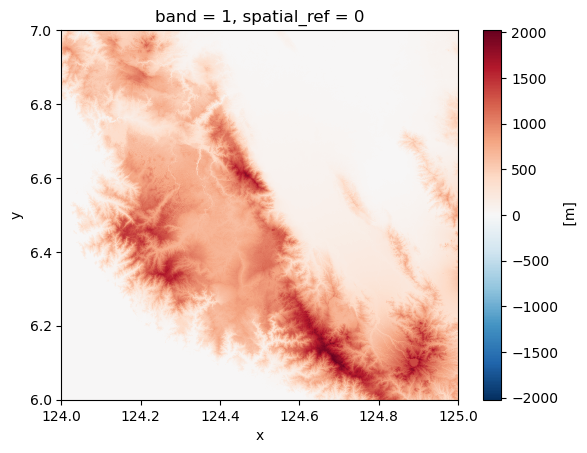

In [1]:
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
# load the raster data and display
ph_dem = rioxarray.open_rasterio('./data/n06_e124_1arc_v3.tif') #('data/U4234A.tif')
ph_dem.plot()

In [2]:
# perform slope calculation
# Get the pixel resolution
xres = ph_dem.rio.resolution()[0]  # Resolution in x direction (longitude)
yres = ph_dem.rio.resolution()[1]  # Resolution in y direction (latitude)

# Calculate gradients in the x and y directions
dzdx = ph_dem.differentiate(coord='x') / xres  # Gradient in the x direction
dzdy = ph_dem.differentiate(coord='y') / yres  # Gradient in the y direction

# Calculate the slope (in degrees)
slope = np.sqrt(dzdx**2 + dzdy**2)
slope = np.arctan(slope) * (180 / np.pi)

# Update the attributes to reflect that this is a slope raster
slope.attrs['long_name'] = 'Slope'
slope.attrs['units'] = 'degrees'

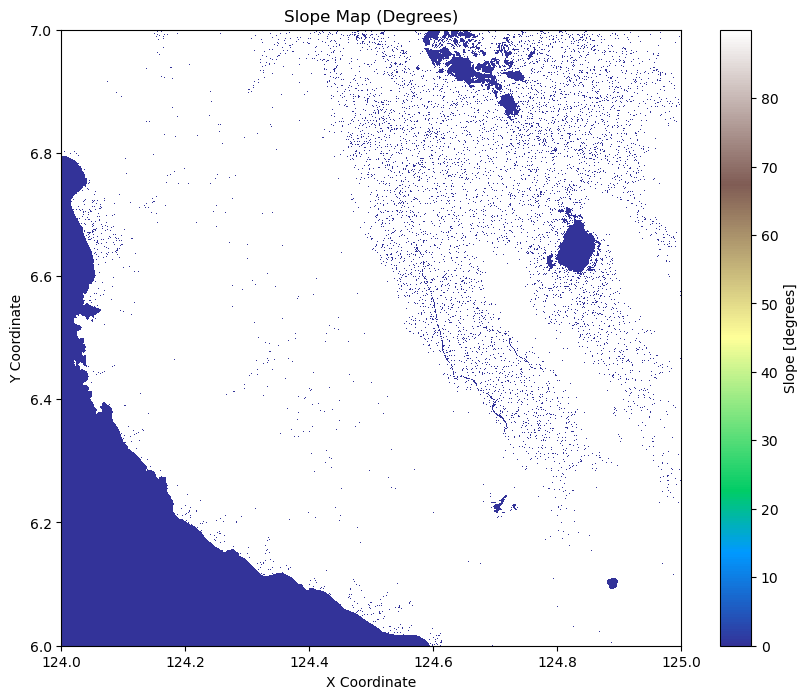

In [3]:
# Plot the slope raster
plt.figure(figsize=(10, 8))
slope.plot(cmap='terrain', add_colorbar=True)
plt.title("Slope Map (Degrees)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.show()

### Slope stability index (SSI)

The Slope Stability Index can be calculated from
$$
\text{SSI} = \frac{1}{\text{Slope} \times \text{Elevation}}
$$
 
- Slope: The steepness of the terrain, typically measured in degrees or percentage.
- Elevation (DEM): The height of the terrain above a reference point (usually sea level).

**Interpretation**

- The lower the value of the SSI, the higher the instability risk.
- Conversely, higher values indicate more stable terrain.

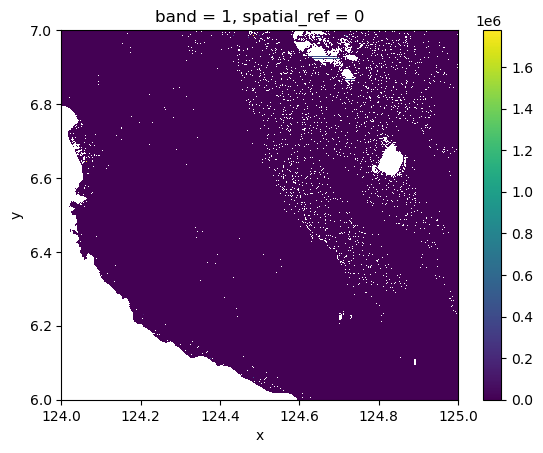

In [4]:
import numpy as np
import rioxarray as rxr

# Read the first band
slope = slope[0]
dem = ph_dem[0]

# Avoid division by zero by setting zero or negative DEM values to NaN
dem = ph_dem.where(dem > 0)

# Calculate the Slope Stability Index (SSI)
ssi = 1 / (slope * dem)

# Handle any infinities resulting from division by zero (set them to NaN)
ssi = ssi.where(np.isfinite(ssi), np.nan)

# Update SSI attributes to match input slope raster
ssi.rio.write_crs(slope.rio.crs)
ssi.rio.write_nodata(np.nan, inplace=True)

# Save the result as a GeoTIFF
ssi.plot()

### Conclusions

We remark that almost the entire region has very low values of SSI, and is potentially at high risk of landslides induced by seismic events.

### Exercises

1. Analyze the 3 remaining DEM files in the `data` directory.
2. Register on the USGS site and download DEM files for all the other regions in the Philippines.
3. Analyze these regions for slope stability and generate a report for the global evaluation of slope stabiltyi n the Philippines.